# OOD Detection Pipeline

## 1. Load data to obtain hidden representations.

### Datasets

In [1]:
from constants.data_constants import JORDAN_DATASET_FILEPATH, MAESTRO_DATASET_FILEPATH
from data.jordan_dataset import JordanDataset
from data.maestro_dataset import MaestroDataset


print("Loading Jordan dataset - train")
id_train_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train",
    name="id_train_dataset"
)
print(f"Obtained {len(id_train_dataset)} training examples from Jordan dataset - train")

print("Loading Jordan dataset - test")
id_test_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation",
    name="id_test_dataset"
)
print(f"Obtained {len(id_test_dataset)} testing examples from Jordan dataset - test")

print("Loading Maestro dataset - test")
ood_dataset = MaestroDataset(
    data_dir=MAESTRO_DATASET_FILEPATH,
    split="test",
    name="maestro_test_dataset"
)
print(f"Obtained {len(ood_dataset)} testing examples from Maestro dataset - test")

/data/scratch/joeltjy1/conda_envs/ood-detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Jordan dataset - train
Loading train split from /scratch/joel/jordan_dataset...
Loaded 4060 samples from train split
Sample keys: ['input_ids', 'labels']
Skipped 490 bad samples
Obtained 4060 training examples from Jordan dataset - train
Loading Jordan dataset - test
Loading validation split from /scratch/joel/jordan_dataset...
Loaded 84 samples from validation split
Sample keys: ['input_ids', 'labels']
Skipped 0 bad samples
Obtained 84 testing examples from Jordan dataset - test
Loading Maestro dataset - test
path /scratch/joel/maestrodata/test.txt
Obtained 962 testing examples from Maestro dataset - test


### DataLoaders

In [2]:
from torch.utils.data import DataLoader
from utils.data_loading import collate_fn

batch_size = 8

id_train_dataloader = DataLoader(id_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
id_test_dataloader = DataLoader(id_test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
ood_dataloader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


### Model

In [3]:
from constants.model_constants import DEVICE, JORDAN_MODEL_NAME
import torch
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    JORDAN_MODEL_NAME,
    dtype=torch.float32,
).to(DEVICE)

# 2. OOD Detector

Refer to [OOD detection docs](../../docs/ood_detection.md) for more information about this.

In [4]:
from main.transformation_functions import extract_layer_with_mean_std_pooling
from main.transformations import Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from main.scoring_functions import mahalanobis_distance

transformations = Transformations(
    [
        extract_layer_with_mean_std_pooling(model, [12]),
        PCA(n_components=10),
        StandardScaler(),
    ]
) # this is IN ADDITION to the extraction done in extract_layers.py
scoring_function = mahalanobis_distance

## Create OOD detector
from transformations and scoring function

In [5]:
from main.ood_detector import OODDetector

ood_detector = OODDetector(
    embedding_function=transformations,
    scoring_function=scoring_function,
    id_train_data=id_train_dataloader,
)

Extracting representations from id_train_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028,

Extracting representations from id_train_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028,

We can evaluate the detector!

```threshold = 0.7``` with ```threshold_type = "percentile"``` means that the score threshold is set to be the 70th percentile of all the scores (ID test + OOD test combined).

In [6]:
confusion_matrix, true_positive_rate, false_positive_rate = ood_detector.evaluate(
    id_test_dataloader,
    ood_dataloader,
    threshold=0.7,
    threshold_type="percentile",
)
print("Confusion matrix:", confusion_matrix)
print("True positive rate:", true_positive_rate)
print("False positive rate:", false_positive_rate)


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

Extracting hidden states:   0%|          | 0/11 [00:00<?, ?it/s]

25 torch.Size([8, 766, 1024])


/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/utils/data_loading.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(ex["input_ids"], dtype=torch.long) for ex in examples]
Extracting hidden states:   9%|▉         | 1/11 [00:00<00:03,  2.64it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  18%|█▊        | 2/11 [00:00<00:02,  3.39it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  27%|██▋       | 3/11 [00:00<00:02,  3.68it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  36%|███▋      | 4/11 [00:01<00:01,  3.87it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  45%|████▌     | 5/11 [00:01<00:01,  3.91it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  55%|█████▍    | 6/11 [00:01<00:01,  3.96it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  64%|██████▎   | 7/11 [00:01<00:01,  3.99it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  73%|███████▎  | 8/11 [00:02<00:00,  4.02it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states:  82%|████████▏ | 9/11 [00:02<00:00,  4.04it/s]

25 torch.Size([8, 766, 1024])


Extracting hidden states: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]


25 torch.Size([4, 766, 1024])
Saved layer 12: (84, 2048)
Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)


Extracting hidden states:   0%|          | 0/121 [00:00<?, ?it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   1%|          | 1/121 [00:00<00:34,  3.50it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   2%|▏         | 2/121 [00:00<00:36,  3.28it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   2%|▏         | 3/121 [00:00<00:36,  3.21it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   3%|▎         | 4/121 [00:01<00:36,  3.16it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   4%|▍         | 5/121 [00:01<00:36,  3.15it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   5%|▍         | 6/121 [00:01<00:36,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   6%|▌         | 7/121 [00:02<00:36,  3.14it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   7%|▋         | 8/121 [00:02<00:36,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   7%|▋         | 9/121 [00:02<00:35,  3.12it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   8%|▊         | 10/121 [00:03<00:35,  3.12it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:   9%|▉         | 11/121 [00:03<00:35,  3.14it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  10%|▉         | 12/121 [00:03<00:34,  3.16it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  11%|█         | 13/121 [00:04<00:34,  3.14it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  12%|█▏        | 14/121 [00:04<00:34,  3.14it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  12%|█▏        | 15/121 [00:04<00:33,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  13%|█▎        | 16/121 [00:05<00:33,  3.17it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  14%|█▍        | 17/121 [00:05<00:33,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  15%|█▍        | 18/121 [00:05<00:32,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  16%|█▌        | 19/121 [00:06<00:32,  3.14it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  17%|█▋        | 20/121 [00:06<00:32,  3.12it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  17%|█▋        | 21/121 [00:06<00:32,  3.11it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  18%|█▊        | 22/121 [00:07<00:31,  3.11it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  19%|█▉        | 23/121 [00:07<00:31,  3.12it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  20%|█▉        | 24/121 [00:07<00:31,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  21%|██        | 25/121 [00:07<00:31,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  21%|██▏       | 26/121 [00:08<00:30,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  22%|██▏       | 27/121 [00:08<00:30,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  23%|██▎       | 28/121 [00:08<00:30,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  24%|██▍       | 29/121 [00:09<00:29,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  25%|██▍       | 30/121 [00:09<00:29,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  26%|██▌       | 31/121 [00:09<00:29,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  26%|██▋       | 32/121 [00:10<00:28,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  27%|██▋       | 33/121 [00:10<00:28,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  28%|██▊       | 34/121 [00:10<00:28,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  29%|██▉       | 35/121 [00:11<00:27,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  30%|██▉       | 36/121 [00:11<00:27,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  31%|███       | 37/121 [00:11<00:27,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  31%|███▏      | 38/121 [00:12<00:26,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  32%|███▏      | 39/121 [00:12<00:26,  3.12it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  33%|███▎      | 40/121 [00:12<00:26,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  34%|███▍      | 41/121 [00:13<00:25,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  35%|███▍      | 42/121 [00:13<00:25,  3.13it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  36%|███▌      | 43/121 [00:13<00:25,  3.11it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  36%|███▋      | 44/121 [00:14<00:24,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  37%|███▋      | 45/121 [00:14<00:24,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  38%|███▊      | 46/121 [00:14<00:24,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  39%|███▉      | 47/121 [00:15<00:23,  3.10it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  40%|███▉      | 48/121 [00:15<00:23,  3.09it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  40%|████      | 49/121 [00:15<00:23,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  41%|████▏     | 50/121 [00:16<00:23,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  42%|████▏     | 51/121 [00:16<00:22,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  43%|████▎     | 52/121 [00:16<00:22,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  44%|████▍     | 53/121 [00:17<00:22,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  45%|████▍     | 54/121 [00:17<00:21,  3.08it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  45%|████▌     | 55/121 [00:17<00:21,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  46%|████▋     | 56/121 [00:18<00:21,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  47%|████▋     | 57/121 [00:18<00:20,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  48%|████▊     | 58/121 [00:18<00:20,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  49%|████▉     | 59/121 [00:18<00:20,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  50%|████▉     | 60/121 [00:19<00:19,  3.07it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  50%|█████     | 61/121 [00:19<00:19,  3.05it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  51%|█████     | 62/121 [00:19<00:19,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  52%|█████▏    | 63/121 [00:20<00:18,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  53%|█████▎    | 64/121 [00:20<00:18,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  54%|█████▎    | 65/121 [00:20<00:18,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  55%|█████▍    | 66/121 [00:21<00:18,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  55%|█████▌    | 67/121 [00:21<00:17,  3.05it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  56%|█████▌    | 68/121 [00:21<00:17,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  57%|█████▋    | 69/121 [00:22<00:17,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  58%|█████▊    | 70/121 [00:22<00:16,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  59%|█████▊    | 71/121 [00:22<00:16,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  60%|█████▉    | 72/121 [00:23<00:16,  3.05it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  60%|██████    | 73/121 [00:23<00:15,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  61%|██████    | 74/121 [00:23<00:15,  3.05it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  62%|██████▏   | 75/121 [00:24<00:15,  3.06it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  63%|██████▎   | 76/121 [00:24<00:14,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  64%|██████▎   | 77/121 [00:24<00:14,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  64%|██████▍   | 78/121 [00:25<00:14,  3.04it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  65%|██████▌   | 79/121 [00:25<00:13,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  66%|██████▌   | 80/121 [00:25<00:13,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  67%|██████▋   | 81/121 [00:26<00:13,  3.02it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  68%|██████▊   | 82/121 [00:26<00:12,  3.02it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  69%|██████▊   | 83/121 [00:26<00:12,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  69%|██████▉   | 84/121 [00:27<00:12,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  70%|███████   | 85/121 [00:27<00:11,  3.02it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  71%|███████   | 86/121 [00:27<00:11,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  72%|███████▏  | 87/121 [00:28<00:11,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  73%|███████▎  | 88/121 [00:28<00:10,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  74%|███████▎  | 89/121 [00:28<00:10,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  74%|███████▍  | 90/121 [00:29<00:10,  3.02it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  75%|███████▌  | 91/121 [00:29<00:09,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  76%|███████▌  | 92/121 [00:29<00:09,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  77%|███████▋  | 93/121 [00:30<00:09,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  78%|███████▊  | 94/121 [00:30<00:08,  3.03it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  79%|███████▊  | 95/121 [00:30<00:08,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  79%|███████▉  | 96/121 [00:31<00:08,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  80%|████████  | 97/121 [00:31<00:08,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  81%|████████  | 98/121 [00:31<00:07,  3.01it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  82%|████████▏ | 99/121 [00:32<00:07,  2.99it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  83%|████████▎ | 100/121 [00:32<00:07,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  83%|████████▎ | 101/121 [00:32<00:06,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  84%|████████▍ | 102/121 [00:33<00:06,  2.99it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  85%|████████▌ | 103/121 [00:33<00:06,  2.99it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  86%|████████▌ | 104/121 [00:33<00:05,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  87%|████████▋ | 105/121 [00:34<00:05,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  88%|████████▊ | 106/121 [00:34<00:05,  2.99it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  88%|████████▊ | 107/121 [00:34<00:04,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  89%|████████▉ | 108/121 [00:35<00:04,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  90%|█████████ | 109/121 [00:35<00:04,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  91%|█████████ | 110/121 [00:35<00:03,  3.00it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  92%|█████████▏| 111/121 [00:36<00:03,  2.99it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  93%|█████████▎| 112/121 [00:36<00:03,  2.98it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  93%|█████████▎| 113/121 [00:36<00:02,  2.97it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  94%|█████████▍| 114/121 [00:37<00:02,  2.96it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  95%|█████████▌| 115/121 [00:37<00:02,  2.96it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  96%|█████████▌| 116/121 [00:37<00:01,  2.97it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  97%|█████████▋| 117/121 [00:38<00:01,  2.97it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  98%|█████████▊| 118/121 [00:38<00:01,  2.96it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states:  98%|█████████▊| 119/121 [00:38<00:00,  2.97it/s]

25 torch.Size([8, 1024, 1024])


Extracting hidden states: 100%|██████████| 121/121 [00:39<00:00,  3.07it/s]


25 torch.Size([2, 1024, 1024])
Saved layer 12: (962, 2048)
Confusion matrix: tensor([[306, 656],
        [  8,  76]])
True positive rate: tensor(0.3181)
False positive rate: tensor(0.0952)


We can plot the ROC curve and get AUROC!

AUROC will appear as ```main/auroc.png```

Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Representations already exist for maestro_test_dataset dataset with pool_mean_stdpooling function for layers: [12]. Loading from /scratch/joel/representations/maestro_test_dataset/pool_mean_std.
Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
         

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/oo

Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Representations already exist for maestro_test_dataset dataset with pool_mean_stdpooling function for layers: [12]. Loading from /scratch/joel/representations/maestro_test_dataset/pool_mean_std.
Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
         

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from maestro_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),
/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


Extracting representations from id_test_dataset dataset
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(55028, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=55028, 

/afs/csail.mit.edu/u/j/joeltjy1/ood-detection/src/main/ood_detector.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold, dtype=all_scores.dtype),


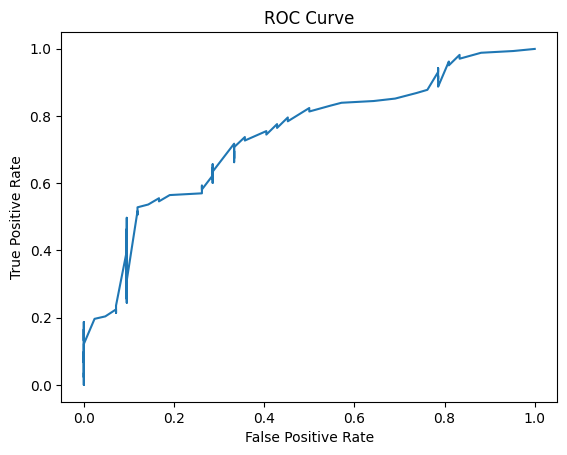

In [8]:
from eval.auroc import get_auroc

auroc = get_auroc(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

THIS IS SO SUS i think it needs to be debugged...

In [9]:
print("AUROC:", auroc)



AUROC: 0.7367711067199707
